# Active learning loop

## Install and load relevant packages

In [ ]:
import sys
import os

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# if in colab
if sys.argv[0] == '/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py':
    #%pip install "argilla[server, listeners]==1.1.1"
    %pip install "transformers[sentencepiece]~=4.26"
    %pip install "datasets~=2.8"
    #%pip install "small-text[transformers]~=1.1.1"
    #%pip install "colab-xterm~=0.1.2"


Mon Feb 13 11:10:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    42W / 400W |      3MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# info on the GPU you are using
print(sys.argv)
# if in colab
if sys.argv[0] == '/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py':
    !nvidia-smi
    # info on available ram
    from psutil import virtual_memory
    ram_gb = virtual_memory().total / 1e9
    print('\n\nYour runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/PhD/validity
/content/drive/My Drive/PhD/validity


In [ ]:
## connect to your google drive in case you want to load and save your own data
# if in colab
if sys.argv[0] == '/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py':
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    #drive.flush_and_unmount()

    print(os.getcwd())
    os.chdir("/content/drive/My Drive/PhD/validity")
    print(os.getcwd())


In [ ]:
## load local modules
#sys.path.append("/content/drive/My Drive/PhD/validity")
sys.path.insert(0, os.getcwd())
import active_learning_v2
import importlib  # in case of manual updates in .py file
importlib.reload(active_learning_v2)

from active_learning_v2 import ActiveLearner

In [ ]:
## import non-local packages
import numpy as np
import pandas as pd
import torch
import datasets
import copy

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, 
    AutoConfig, AutoModelForNextSentencePrediction,
    TrainingArguments, Trainer
)

from sklearn.metrics import balanced_accuracy_score, precision_recall_fscore_support, accuracy_score, classification_report
from sklearn.model_selection import train_test_split



## Set main arguments

In [ ]:
DATASET = "pimpo"  # "pimpo", "uk-leftright-econ"
TRAINING_DIRECTORY = f"results/{DATASET}"

MAX_SAMPLE = 50_000
N_SAMPLE_AL = 50
N_ITER_MAX = 20 
DATE = 20230207
TASK = "pimpo"
METHOD = "nli"   #args.method
MODEL_NAME = "MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli"  #"MoritzLaurer/DeBERTa-v3-xsmall-mnli-fever-anli-ling-binary", "MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli", "MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli"
VECTORIZER = "en"  #args.vectorizer

# set global seed for reproducibility and against seed hacking
#N_ITER = 0  #args.n_iteration - 1
#N_ITER_MAX = 1  #args.n_iterations_max
SEED_GLOBAL = 42
np.random.seed(SEED_GLOBAL)

# special variables for pimpo
#SAMPLE_NO_TOPIC = 10
#TRAIN_NOTOPIC_PROPORTION = 0.4

# randomly assign different seeds for each run
"""seed_runs_all = np.random.choice(range(1000), size=N_ITER_MAX)
SEED_RUN = seed_runs_all[N_ITER]
print("Iteration number: ", N_ITER)
print("All random seeds: ", seed_runs_all)
print("Random seed for this run: ", SEED_RUN)"""

# not sure if I should keep TASK variable
assert DATASET in TASK, f"Mismatch between dataset {DATASET} and task {TASK}"

In [ ]:
MODEL_MAX_LENGTH = 256
HYPER_PARAMS_DIC = {
    'lr_scheduler_type': 'linear', 'learning_rate': 2e-5, 'num_train_epochs': 7, 'seed': SEED_GLOBAL, 
    'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 64*10, 
    'warmup_ratio': 0.50, 'weight_decay': 0.01
}  # "do_eval": False
TRAINING_DIRECTORY = ""
FP16_BOOL = True if torch.cuda.is_available() else False # FP16 if cuda and if not mDeBERTa
if "mDeBERTa".lower() in MODEL_NAME.lower(): FP16_BOOL = False  # mDeBERTa does not support FP16 yet
# try bf16?
BF16_BOOL = True
if BF16_BOOL == True: FP16_BOOL = False


'import sys\nsys.path.insert(0, os.getcwd())\nimport helpers\nimport importlib  # in case of manual updates in .py file\nimportlib.reload(helpers)\nfrom helpers import compute_metrics_standard, clean_memory, compute_metrics_nli_binary\n#from helpers import load_model_tokenizer, tokenize_datasets, set_train_args, create_trainer, format_nli_trainset, format_nli_testset\n'

In [ ]:
# ## Load helper functions
"""import sys
sys.path.insert(0, os.getcwd())
import helpers
import importlib  # in case of manual updates in .py file
importlib.reload(helpers)
from helpers import compute_metrics_standard, clean_memory, compute_metrics_nli_binary
#from helpers import load_model_tokenizer, tokenize_datasets, set_train_args, create_trainer, format_nli_trainset, format_nli_testset
"""

## Load and clean data

In [ ]:
## load data
if DATASET == "uk-leftright-econ":
    df = pd.read_csv(f"./data-clean/benoit_leftright_sentences.zip", engine='python')
    df_cl = df.copy(deep=True)
elif "pimpo" in DATASET:
    # df = pd.read_csv(f"/Users/moritzlaurer/Dropbox/PhD/Papers/multilingual/multilingual-repo/data-clean/df_pimpo_samp_trans_m2m_100_1.2B_embed_tfidf.zip", engine='python')
    df = pd.read_csv("./data-clean/df_pimpo_samp_trans_lemmatized_stopwords.zip", engine="python")
    df_cl = df.copy(deep=True)
else:
    raise Exception(f"Dataset name not found: {DATASET}")

In [ ]:

## uk-leftright
if "uk-leftright-econ" in DATASET:
    # select to work with crowd annotations and expert annotations
    df_cl = df_cl[df_cl.source == "Crowd"]
    # select task on either economy or social policy
    df_cl = df_cl[df_cl.scale == "Economic"]
    # transform continuous float data to categorical classes
    df_cl["label_scale"] = df_cl.score_sent_mean.fillna(0).round().astype(int)
    print(df_cl["label_scale"].value_counts())
    # prepare input data
    df_cl["text_prepared"] = df_cl["text_preceding"].fillna('') + " " + df_cl["text_original"] + " " + df_cl["text_following"].fillna('')
elif "uk-leftright-soc" in DATASET:
    raise NotImplementedError

if "uk-leftright" in DATASET:
    ## simplify scale to three classes for label text
    task_label_text_map = {0: "neutral", 1: "right", 2: "right", -1: "left", -2: "left"}
    # could also test scale as 5 classes
    #task_label_text_map = {0: "neutral", 1: "right", 2: "very_right", -1: "left", -2: "very_left"}
    df_cl["label_text"] = df_cl.label_scale.map(task_label_text_map)
    print(df_cl["label_text"].value_counts())
    ## adapt numeric label
    task_label_text_map_factorized = {"neutral": 1, "right": 2, "right": 2, "left": 0, "left": 0}
    #task_label_text_map_factorized = {"neutral": 2, "right": 3, "very_right": 4, "left": 1, "very_left": 0}
    df_cl["label"] = df_cl["label_text"].map(task_label_text_map_factorized)
    print(df_cl["label"].value_counts())


# remove x% no_topic for faster testing
if "pimpo" in DATASET:
    #df_cl = df_cl.groupby(by="label_text", as_index=False, group_keys=False).apply(lambda x: x.sample(n=min(SAMPLE_NO_TOPIC, len(x)), random_state=SEED_GLOBAL) if x.label_text.iloc[0] == "no_topic" else x)
    #print(df_cl["label_text"].value_counts())
    df_cl["text_prepared"] = df_cl.text_preceding_trans.fillna("") + '  || The quote: "' + df_cl.text_original_trans.fillna("") + '" End of the quote ||  ' + df_cl.text_following_trans.fillna("") 


label_text_alphabetical = np.sort(df_cl.label_text.unique())


no_topic                  50000
integration_supportive     3850
immigration_supportive     1887
immigration_sceptical      1432
integration_sceptical       818
immigration_neutral         579
integration_neutral         394
Name: label_text, dtype: int64


In [ ]:
# sample training data
if "uk-leftright" in DATASET:
    df_train = df_cl.sample(n=MAX_SAMPLE, random_state=SEED_GLOBAL)
elif "pimpo" in DATASET:
    # sample x% of training data for no topic, then share the remainder equally across classes
    """ n_sample_notopic = int(MAX_SAMPLE * TRAIN_NOTOPIC_PROPORTION)
    n_sample_perclass = int((MAX_SAMPLE - n_sample_notopic) / (len(df_cl.label_text.unique()) - 1))
    df_train_samp1 = df_cl.groupby("label_text", as_index=False, group_keys=False).apply(
        lambda x: x.sample(min(n_sample_perclass, len(x)), random_state=SEED_GLOBAL) if x.label_text.unique()[0] != "no_topic" else None)
    df_train_samp2 = df_cl[df_cl.label_text == "no_topic"].sample(n_sample_notopic, random_state=SEED_GLOBAL)
    df_train = pd.concat([df_train_samp1, df_train_samp2])"""
    
    df_corpus = df_cl.groupby(by="label_text", as_index=False, group_keys=False).apply(lambda x: x.sample(n=min(MAX_SAMPLE, len(x)), random_state=SEED_GLOBAL) if x.label_text.iloc[0] == "no_topic" else x)
    #df_corpus = df_cl.sample(n=MAX_SAMPLE, random_state=SEED_GLOBAL).copy(deep=True)

print(df_corpus.label_text.value_counts())

# create df test
# just to get accuracy figure as benchmark, less relevant for substantive use-case
#df_test = df_cl[~df_cl.index.isin(df_train.index)]
#assert len(df_train) + len(df_test) == len(df_cl)

# make df_test smaller for quick testing: 
#df_test = df_test.sample(n=MAX_SAMPLE, random_state=SEED_GLOBAL)
#print(df_test.label_text.value_counts())


In [ ]:
## data checks
# verify that numeric label is in alphabetical order of label_text (can avoid issues for NLI)
labels_num_via_numeric = df_cl[~df_cl.label_text.duplicated(keep="first")].sort_values("label_text").label.tolist()  # label num via labels: get labels from data when ordering label text alphabetically
labels_num_via_text = pd.factorize(np.sort(df_cl.label_text.unique()))[0]  # label num via label_text: create label numeric via label text
assert all(labels_num_via_numeric == labels_num_via_text)

In [ ]:
## nli hypotheses
if METHOD == "nli":
    HYPO_LABEL_DIC = {
            "immigration_neutral": "The quote describes immigration neutrally without implied value judgement or describes the status quo of immigration, for example only stating facts or using technocratic language about immigration",
            "immigration_sceptical": "The quote describes immigration sceptically / disapprovingly. For example, the quote could mention the costs of immigration, be against migrant workers, state that foreign labour decreases natives' wages, that there are already enough refugees, refugees are actually economic migrants, be in favour of stricter immigration controls, exceptions to the freedom of movement in the EU.",
            "immigration_supportive": "The quote describes immigration favourably / supportively. For example, the quote could mention the benefits of immigration, the need for migrant workers, international obligations to take in refugees, protection of human rights, in favour of family reunification or freedom of movement in the EU.",
            "integration_neutral": "The quote describes immigrant integration neutrally without implied value judgement or describes the status quo of immigrant integration, for example only stating facts or using technocratic language about immigrant integration",
            "integration_sceptical": "The quote describes immigrant integration sceptically / disapprovingly. For example, the quote could mention negative references to multiculturalism and diversity, underline the importance of ethnic homogeneity and national culture, call for immigrants to give up their culture of origin, warn of islamization, mention duties in order to stay in the country, demand integration tests, associate immigrant communities with problems or crimes, demand an oath of allegiance of immigrants, or underline ethnic criteria for receiving citizenship.",
            "integration_supportive": "The quote describes immigrant integration favourably / supportively. For example, the quote could mention positive references to multiculturalism and diversity, underline cosmopolitan values towards immigrants, demand inclusion of immigrants, demand anti-discrimination policies based on ethnicity and origin, demand policies against racism, demand more rights for immigrants, or underline civic values instead of ethnic values for being able to receive citizenship.",            
            "no_topic": "The quote is neither about immigration nor about immigrant integration.",
    }
else:
    raise NotImplementedError



In [ ]:
# label_map necessary downstream
#label_map = {label_text: label for label, label_text in zip(np.unique(df_cl["label_text"].factorize(sort=False)[0]), df_cl["label_text"].factorize(sort=False)[1])}

#df_cl = df_cl[["label", "label_text", "text"]]  # "label_text", 
#df_cl = df_cl.reset_index(drop=True)

## Initialise the active learner

In [ ]:
# ?! does it make sense to split this, or should I just always run on all and then remove new sampled texts from df_test and add to corpus/train?
# ! should work for both non-annotation loop and in annotation loop
# could remove the double inference step ?
#df_corpus, df_test = train_test_split(df_cl, train_size=0.5, random_state=SEED_GLOBAL, stratify=df_cl["label_text"])
#df_corpus = df_train
#df_test = df_test

Number of hypotheses/classes:  7 

For normal test, N classifications necessary: 58960
For NLI test, N classifications necessary: 412720



In [ ]:
learner = ActiveLearner()

learner.load_pd_dataset(df_corpus=df_corpus, text_column="text_prepared", separate_testset=False)  # df_test=df_test
learner.format_pd_dataset_for_nli(hypo_label_dic=HYPO_LABEL_DIC)
#learner.format_pd_trainset_for_nli(hypo_label_dic=HYPO_LABEL_DIC)
#learner.format_pd_testset_for_nli(hypo_label_dic=HYPO_LABEL_DIC)

#learner.df_test_format
#learner.df_test_original
#learner.df_corpus_format
#learner.df_corpus_original
#learner.df_corpus_original_update

/usr/local/lib/python3.8/dist-packages/transformers/convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Device: cuda


In [ ]:
# only for first run
learner.load_model_tokenizer(model_name=MODEL_NAME, method=METHOD, label_text_alphabetical=label_text_alphabetical, model_max_length=MODEL_MAX_LENGTH)


  0%|          | 0/413 [00:00<?, ?ba/s]

In [ ]:
learner.tokenize_hf_dataset()


In [ ]:
learner.set_train_args(hyperparams_dic=HYPER_PARAMS_DIC, training_directory=TRAINING_DIRECTORY, disable_tqdm=False, evaluation_strategy="no", fp16=FP16_BOOL, bf16=BF16_BOOL)


Using cuda_amp half precision backend
The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: text_following, rn, idx, text_prepared, parfam, label_text, parfam_text, language_iso, text_preceding, direction, partyname, text_preceding_trans, certainty_selection, text_following_trans, text_original_trans, hypothesis, text_original, cmp_code, country_iso, topic, selection, certainty_topic, language_iso_fasttext, partyabbrev, date, doc_id, language_iso_trans, text_trans_concat_tfidf, certainty_direction. If text_following, rn, idx, text_prepared, parfam, label_text, parfam_text, language_iso, text_preceding, direction, partyname, text_preceding_trans, certainty_selection, text_following_trans, text_original_trans, hypothesis, text_original, cmp_code, country_iso, topic, selection, certainty_topic, language_iso_fasttext, partyabbrev, date, doc_id, language_iso_trans, text_trans_concat_tfidf, certa

Aggregate metrics:  {'f1_macro': 0.18708357519323013, 'f1_micro': 0.44886363636363635, 'accuracy_balanced': 0.2837292310996416, 'accuracy_not_b': 0.44886363636363635, 'precision_macro': 0.20706836504511425, 'recall_macro': 0.2837292310996416, 'precision_micro': 0.44886363636363635, 'recall_micro': 0.44886363636363635}
Detailed metrics:  {'immigration_neutral': {'precision': 0.008, 'recall': 0.13989637305699482, 'f1-score': 0.015134529147982063, 'support': 579}, 'immigration_sceptical': {'precision': 0.1393125426815388, 'recall': 0.4273743016759777, 'f1-score': 0.21012875536480685, 'support': 1432}, 'immigration_supportive': {'precision': 0.12253968253968255, 'recall': 0.10227874933757286, 'f1-score': 0.11149624494511842, 'support': 1887}, 'integration_neutral': {'precision': 0.009777777777777778, 'recall': 0.027918781725888325, 'f1-score': 0.014483212639894669, 'support': 394}, 'integration_sceptical': {'precision': 0.044964951273722006, 'recall': 0.3215158924205379, 'f1-score': 0.0788

1

In [ ]:
### first zero-shot sampling % testing run, no training
learner.train_test_infer()
learner.n_iteration
#learner.results_test
#learner.results_corpus

[42983, 51846, 35385, 35026, 2871, 76503, 2650, 42223, 54783, 18661, 78750, 34806, 3689, 5874, 34790, 76037, 90137, 52400, 69883, 64914, 5877, 55654, 98235, 9868, 75143, 51528, 34962, 70280, 74856, 105275, 44138, 80081, 3233, 4164, 50423, 34716, 34866, 63284, 23329, 51888, 6299, 56032, 93317, 76575, 12604, 76234, 69840, 78826, 29116, 51687]
[]


In [ ]:
#index_al_sample_init, df_corpus_ties_sample = breaking_ties(results_corpus=results_corpus, df_corpus=df_corpus, label_text_alphabetical=label_text_alphabetical, n_sample_al=N_SAMPLE_AL)
learner.sample_breaking_ties(n_sample_al=N_SAMPLE_AL)
print(learner.index_al_sample)
print(learner.index_train_all)
#learner.df_corpus_al_sample

## Active learning loop from existing annotations

In [ ]:
n_iter = 0
sample_label_distribution = []

while n_iter < N_ITER_MAX: 
    #_ = input()

    ## this is where annotation needs to happen
    # dataset_train in update below needs to ingest the manual annotations created here (or oracle labels)
    # ! need to make it work without and with existing gold labels
    label_annotation = learner.df_corpus_al_sample["label"]
    
    # save label distributions to test impact of sampling strategy on balance
    #print("\n\n", learner.df_corpus_al_sample["label_text"].value_counts(), "\n\n")
    sample_label_distribution_iter = learner.df_corpus_al_sample["label_text"].value_counts()
    sample_label_distribution_iter.name = n_iter
    sample_label_distribution.append(sample_label_distribution_iter)

    # with first dataset update, a dataset_train is added
    # with all updates, dataset_train and dataset_corpus is updated
    #print(learner.dataset)
    learner.update_dataset(label_annotation=label_annotation)
    #print(learner.dataset)
    # ! note: test rows are multiplied by n_label, train rows are n_sample_al * 2

    ## training run
    learner.train_test_infer()

    # print results
    for key_iter, value_metrics_dic in learner.metrics.items():
        print(f"Aggregate metrics for {key_iter}: ", {key: value_metrics_dic[key] for key in value_metrics_dic if key not in ["label_gold_raw", "label_predicted_raw"]})  # print metrics but without label lists

    # new sampling run before updating the dataset. need new index_al_sample
    learner.sample_breaking_ties(n_sample_al=N_SAMPLE_AL)
    
    print(f"\n\n    Iteration {n_iter} finished.\n\n")
    n_iter += 1






"\nAggregate metrics for iter_0:  {'eval_loss': 0.5628172755241394, 'eval_f1_macro': 0.10033008782443473, 'eval_f1_micro': 0.18049525101763908, 'eval_accuracy_balanced': 0.20495167826276692, 'eval_accuracy_not_b': 0.18049525101763908, 'eval_precision_macro': 0.20943928165314035, 'eval_recall_macro': 0.20495167826276692, 'eval_precision_micro': 0.18049525101763908, 'eval_recall_micro': 0.18049525101763908, 'eval_runtime': 342.0504, 'eval_samples_per_second': 1206.606, 'eval_steps_per_second': 1.006}\nAggregate metrics for iter_1:  {'eval_loss': 0.6045360565185547, 'eval_f1_macro': 0.15260009714764486, 'eval_f1_micro': 0.8471666101119782, 'eval_accuracy_balanced': 0.16439810608981156, 'eval_accuracy_not_b': 0.8471666101119782, 'eval_precision_macro': 0.33555706572966665, 'eval_recall_macro': 0.16439810608981156, 'eval_precision_micro': 0.8471666101119782, 'eval_recall_micro': 0.8471666101119782, 'eval_runtime': 345.7595, 'eval_samples_per_second': 1193.257, 'eval_steps_per_second': 0.995

In [ ]:
"""
# deberta-v3-xsmall, pimpo 7-class,  20 samp/iter
Aggregate metrics for iter_0:  {'eval_loss': 0.5628172755241394, 'eval_f1_macro': 0.10033008782443473, 'eval_f1_micro': 0.18049525101763908, 'eval_accuracy_balanced': 0.20495167826276692, 'eval_accuracy_not_b': 0.18049525101763908, 'eval_precision_macro': 0.20943928165314035, 'eval_recall_macro': 0.20495167826276692, 'eval_precision_micro': 0.18049525101763908, 'eval_recall_micro': 0.18049525101763908, 'eval_runtime': 342.0504, 'eval_samples_per_second': 1206.606, 'eval_steps_per_second': 1.006}
Aggregate metrics for iter_1:  {'eval_loss': 0.6045360565185547, 'eval_f1_macro': 0.15260009714764486, 'eval_f1_micro': 0.8471666101119782, 'eval_accuracy_balanced': 0.16439810608981156, 'eval_accuracy_not_b': 0.8471666101119782, 'eval_precision_macro': 0.33555706572966665, 'eval_recall_macro': 0.16439810608981156, 'eval_precision_micro': 0.8471666101119782, 'eval_recall_micro': 0.8471666101119782, 'eval_runtime': 345.7595, 'eval_samples_per_second': 1193.257, 'eval_steps_per_second': 0.995, 'epoch': 7.0}
Aggregate metrics for iter_2:  {'eval_loss': 0.4772863984107971, 'eval_f1_macro': 0.26077623269021505, 'eval_f1_micro': 0.8516972165648337, 'eval_accuracy_balanced': 0.29263319995117204, 'eval_accuracy_not_b': 0.8516972165648337, 'eval_precision_macro': 0.36578347167342795, 'eval_recall_macro': 0.29263319995117204, 'eval_precision_micro': 0.8516972165648337, 'eval_recall_micro': 0.8516972165648337, 'eval_runtime': 345.1595, 'eval_samples_per_second': 1194.926, 'eval_steps_per_second': 0.997, 'epoch': 7.0}
Aggregate metrics for iter_3:  {'eval_loss': 0.47742778062820435, 'eval_f1_macro': 0.26043270223998805, 'eval_f1_micro': 0.8612733446519525, 'eval_accuracy_balanced': 0.28025374662633135, 'eval_accuracy_not_b': 0.8612733446519525, 'eval_precision_macro': 0.36634156674514073, 'eval_recall_macro': 0.28025374662633135, 'eval_precision_micro': 0.8612733446519525, 'eval_recall_micro': 0.8612733446519525, 'eval_runtime': 347.2688, 'eval_samples_per_second': 1187.265, 'eval_steps_per_second': 0.991, 'epoch': 7.0}
Aggregate metrics for iter_4:  {'eval_loss': 0.4174456000328064, 'eval_f1_macro': 0.31376364102688165, 'eval_f1_micro': 0.8698539402173914, 'eval_accuracy_balanced': 0.31283989290145314, 'eval_accuracy_not_b': 0.8698539402173913, 'eval_precision_macro': 0.384340706788142, 'eval_recall_macro': 0.31283989290145314, 'eval_precision_micro': 0.8698539402173913, 'eval_recall_micro': 0.8698539402173913, 'eval_runtime': 346.3045, 'eval_samples_per_second': 1190.166, 'eval_steps_per_second': 0.993, 'epoch': 7.0}
Aggregate metrics for iter_5:  {'eval_loss': 0.4523952007293701, 'eval_f1_macro': 0.28008776426269627, 'eval_f1_micro': 0.8661909616038056, 'eval_accuracy_balanced': 0.3104114533290034, 'eval_accuracy_not_b': 0.8661909616038056, 'eval_precision_macro': 0.4061062016477311, 'eval_recall_macro': 0.3104114533290034, 'eval_precision_micro': 0.8661909616038056, 'eval_recall_micro': 0.8661909616038056, 'eval_runtime': 347.1449, 'eval_samples_per_second': 1186.882, 'eval_steps_per_second': 0.991, 'epoch': 7.0}
Aggregate metrics for iter_6:  {'eval_loss': 0.5697242021560669, 'eval_f1_macro': 0.2961691315816643, 'eval_f1_micro': 0.865210740992522, 'eval_accuracy_balanced': 0.30603519038165455, 'eval_accuracy_not_b': 0.865210740992522, 'eval_precision_macro': 0.39979096609180625, 'eval_recall_macro': 0.30603519038165455, 'eval_precision_micro': 0.865210740992522, 'eval_recall_micro': 0.865210740992522, 'eval_runtime': 346.7695, 'eval_samples_per_second': 1187.763, 'eval_steps_per_second': 0.992, 'epoch': 7.0}
Aggregate metrics for iter_7:  {'eval_loss': 0.32757243514060974, 'eval_f1_macro': 0.31114812126500613, 'eval_f1_micro': 0.8739034342060523, 'eval_accuracy_balanced': 0.30836998783057973, 'eval_accuracy_not_b': 0.8739034342060523, 'eval_precision_macro': 0.4103498778685187, 'eval_recall_macro': 0.30836998783057973, 'eval_precision_micro': 0.8739034342060523, 'eval_recall_micro': 0.8739034342060523, 'eval_runtime': 344.2441, 'eval_samples_per_second': 1196.07, 'eval_steps_per_second': 0.999, 'epoch': 7.0}
Aggregate metrics for iter_8:  {'eval_loss': 0.5603343844413757, 'eval_f1_macro': 0.31475080038285846, 'eval_f1_micro': 0.8693197278911564, 'eval_accuracy_balanced': 0.3187929055460235, 'eval_accuracy_not_b': 0.8693197278911564, 'eval_precision_macro': 0.3898263536409363, 'eval_recall_macro': 0.3187929055460235, 'eval_precision_micro': 0.8693197278911564, 'eval_recall_micro': 0.8693197278911564, 'eval_runtime': 345.6567, 'eval_samples_per_second': 1190.777, 'eval_steps_per_second': 0.992, 'epoch': 7.0}
Aggregate metrics for iter_9:  {'eval_loss': 0.47514623403549194, 'eval_f1_macro': 0.30322578859648897, 'eval_f1_micro': 0.8719462402177611, 'eval_accuracy_balanced': 0.31412035033954816, 'eval_accuracy_not_b': 0.8719462402177611, 'eval_precision_macro': 0.39481936275701085, 'eval_recall_macro': 0.31412035033954816, 'eval_precision_micro': 0.8719462402177611, 'eval_recall_micro': 0.8719462402177611, 'eval_runtime': 344.5713, 'eval_samples_per_second': 1194.121, 'eval_steps_per_second': 0.995, 'epoch': 7.0}

# deberta-v3-base, pimpo 7-class,  50 samp/iter
Aggregate metrics for iter_0:  {'eval_loss': 1.0465834140777588, 'eval_f1_macro': 0.18708357519323013, 'eval_f1_micro': 0.44886363636363635, 'eval_accuracy_balanced': 0.2837292310996416, 'eval_accuracy_not_b': 0.44886363636363635, 'eval_precision_macro': 0.20706836504511425, 'eval_recall_macro': 0.2837292310996416, 'eval_precision_micro': 0.44886363636363635, 'eval_recall_micro': 0.44886363636363635, 'eval_runtime': 587.6281, 'eval_samples_per_second': 702.349, 'eval_steps_per_second': 1.098}
Aggregate metrics for iter_1:  {'eval_loss': 0.7379368543624878, 'eval_f1_macro': 0.3540535852129493, 'eval_f1_micro': 0.8555932778815142, 'eval_accuracy_balanced': 0.3962828367929724, 'eval_accuracy_not_b': 0.8555932778815142, 'eval_precision_macro': 0.36594427731868545, 'eval_recall_macro': 0.3962828367929724, 'eval_precision_micro': 0.8555932778815142, 'eval_recall_micro': 0.8555932778815142, 'eval_runtime': 592.2202, 'eval_samples_per_second': 696.312, 'eval_steps_per_second': 1.089, 'epoch': 7.0}
Aggregate metrics for iter_2:  {'eval_loss': 0.23365318775177002, 'eval_f1_macro': 0.3853095478008094, 'eval_f1_micro': 0.882330954808019, 'eval_accuracy_balanced': 0.39244891225949236, 'eval_accuracy_not_b': 0.882330954808019, 'eval_precision_macro': 0.4130412842144277, 'eval_recall_macro': 0.39244891225949236, 'eval_precision_micro': 0.882330954808019, 'eval_recall_micro': 0.882330954808019, 'eval_runtime': 590.1724, 'eval_samples_per_second': 698.135, 'eval_steps_per_second': 1.091, 'epoch': 7.0}
Aggregate metrics for iter_3:  {'eval_loss': 0.31954094767570496, 'eval_f1_macro': 0.3910498559135234, 'eval_f1_micro': 0.8786260839993199, 'eval_accuracy_balanced': 0.38795022533818585, 'eval_accuracy_not_b': 0.8786260839993199, 'eval_precision_macro': 0.45431584606544356, 'eval_recall_macro': 0.38795022533818585, 'eval_precision_micro': 0.8786260839993199, 'eval_recall_micro': 0.8786260839993199, 'eval_runtime': 592.409, 'eval_samples_per_second': 694.908, 'eval_steps_per_second': 1.087, 'epoch': 7.0}
Aggregate metrics for iter_4:  {'eval_loss': 0.14558205008506775, 'eval_f1_macro': 0.42822905247342585, 'eval_f1_micro': 0.8938053097345132, 'eval_accuracy_balanced': 0.4294680989704006, 'eval_accuracy_not_b': 0.8938053097345132, 'eval_precision_macro': 0.4412513971659594, 'eval_recall_macro': 0.4294680989704006, 'eval_precision_micro': 0.8938053097345132, 'eval_recall_micro': 0.8938053097345132, 'eval_runtime': 589.325, 'eval_samples_per_second': 697.951, 'eval_steps_per_second': 1.091, 'epoch': 7.0}
Aggregate metrics for iter_5:  {'eval_loss': 0.2067262977361679, 'eval_f1_macro': 0.4034053528084353, 'eval_f1_micro': 0.8973769374893544, 'eval_accuracy_balanced': 0.4072557747705853, 'eval_accuracy_not_b': 0.8973769374893544, 'eval_precision_macro': 0.44854908851359454, 'eval_recall_macro': 0.4072557747705853, 'eval_precision_micro': 0.8973769374893544, 'eval_recall_micro': 0.8973769374893544, 'eval_runtime': 591.3407, 'eval_samples_per_second': 694.98, 'eval_steps_per_second': 1.087, 'epoch': 7.0}
Aggregate metrics for iter_6:  {'eval_loss': 0.2272566556930542, 'eval_f1_macro': 0.4472755733571036, 'eval_f1_micro': 0.904398227071258, 'eval_accuracy_balanced': 0.43738736733482897, 'eval_accuracy_not_b': 0.904398227071258, 'eval_precision_macro': 0.48463336923636635, 'eval_recall_macro': 0.43738736733482897, 'eval_precision_micro': 0.904398227071258, 'eval_recall_micro': 0.904398227071258, 'eval_runtime': 588.6974, 'eval_samples_per_second': 697.506, 'eval_steps_per_second': 1.091, 'epoch': 7.0}
Aggregate metrics for iter_7:  {'eval_loss': 0.290232390165329, 'eval_f1_macro': 0.42661537998829313, 'eval_f1_micro': 0.8987203548882443, 'eval_accuracy_balanced': 0.42904588924320325, 'eval_accuracy_not_b': 0.8987203548882443, 'eval_precision_macro': 0.4540518816208738, 'eval_recall_macro': 0.42904588924320325, 'eval_precision_micro': 0.8987203548882443, 'eval_recall_micro': 0.8987203548882443, 'eval_runtime': 589.9751, 'eval_samples_per_second': 695.402, 'eval_steps_per_second': 1.088, 'epoch': 7.0}
Aggregate metrics for iter_8:  {'eval_loss': 0.32584547996520996, 'eval_f1_macro': 0.4615640923438204, 'eval_f1_micro': 0.9022711748633878, 'eval_accuracy_balanced': 0.4472825467518498, 'eval_accuracy_not_b': 0.9022711748633879, 'eval_precision_macro': 0.48341487497111035, 'eval_recall_macro': 0.4472825467518498, 'eval_precision_micro': 0.9022711748633879, 'eval_recall_micro': 0.9022711748633879, 'eval_runtime': 588.7656, 'eval_samples_per_second': 696.236, 'eval_steps_per_second': 1.089, 'epoch': 7.0}
Aggregate metrics for iter_9:  {'eval_loss': 0.21070201694965363, 'eval_f1_macro': 0.43570455533758573, 'eval_f1_micro': 0.9026320287130406, 'eval_accuracy_balanced': 0.4140247304519257, 'eval_accuracy_not_b': 0.9026320287130405, 'eval_precision_macro': 0.4980765590865742, 'eval_recall_macro': 0.4140247304519257, 'eval_precision_micro': 0.9026320287130405, 'eval_recall_micro': 0.9026320287130405, 'eval_runtime': 589.1166, 'eval_samples_per_second': 695.227, 'eval_steps_per_second': 1.086, 'epoch': 7.0}
Aggregate metrics for iter_10:  {'eval_loss': 0.15217804908752441, 'eval_f1_macro': 0.45882320773920243, 'eval_f1_micro': 0.9075265138556278, 'eval_accuracy_balanced': 0.45064523080760244, 'eval_accuracy_not_b': 0.9075265138556278, 'eval_precision_macro': 0.4860711524841334, 'eval_recall_macro': 0.45064523080760244, 'eval_precision_micro': 0.9075265138556278, 'eval_recall_micro': 0.9075265138556278, 'eval_runtime': 588.5002, 'eval_samples_per_second': 695.361, 'eval_steps_per_second': 1.088, 'epoch': 7.0}

"""

<ipython-input-60-41a8c6715e88>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corpus_test["label_pred"] = learner.iteration_label_predicted
<ipython-input-60-41a8c6715e88>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corpus_test["label_probabilities"] = learner.iteration_probabilities


,label,label_text,country_iso,language_iso,doc_id,text_original,text_preceding,text_following,selection,certainty_selection,...,language_iso_fasttext,text_preceding_trans,text_original_trans,text_following_trans,language_iso_trans,text_trans_concat_tfidf,text_prepared,label_pred,label_probabilities,label_text_pred
30,0,immigration_neutral,dnk,da,46,og til at sende mennesker tilbage til en meg...,Danmark bidrager i dag til at splitte familier,Det kan vi ikke være bekendt.,1,66.666667,...,da,Denmark contributes to the division of families,And to send people back to a very uncertain ex...,We cannot be familiar with it.,en,Denmark contribute division family send people...,Denmark contributes to the division of familie...,NaN,NaN,NaN
79,0,immigration_neutral,dnk,da,64,Danmark har givet ca. 21.000 tilladelser – Sve...,• Siden 2006 er næsten syv gange så mange udlæ...,”Folke- og førtidspensionister mister årligt o...,1,100.000000,...,da,"Since 2006, almost seven times as many foreign...","Denmark has granted approximately 21,000 permi...","“People and early retirees lose more than 5,00...",en,"2006 , seven time foreigner family reunify Swe...","Since 2006, almost seven times as many foreign...",NaN,NaN,NaN
3224,0,immigration_neutral,deu,de,131,Die FDP hat als erste Partei bereits zu Beginn...,Diese Inkonsequenz führte zu erheblichen Probl...,"Unter Fachleuten ist unstreitig, dass Deutschl...",1,100.000000,...,de,This inconsistency led to significant problems...,The FDP was the first party to introduce a bil...,"Among experts, it is undisputed that Germany w...",en,inconsistency lead significant problem integra...,This inconsistency led to significant problems...,NaN,NaN,NaN
3227,0,immigration_neutral,deu,de,132,Wir werden für eine eindeutige Identitätsfests...,Um den Zuzug gewaltbereiter Ausländer zu unter...,Biometrische Merkmale wie den Fingerabdruck we...,1,66.666667,...,de,In order to prevent the influx of violent fore...,We will ensure unambiguous identification with...,Biometric data such as fingerprints will be in...,en,"order prevent influx violent foreigner , presc...",In order to prevent the influx of violent fore...,NaN,NaN,NaN
3233,0,immigration_neutral,deu,de,133,An Europas südlichen Küsten spielen sich schre...,Terror und Propaganda bedrohen nicht nur das L...,"Jedes Jahr ertrinken, verhungern oder verdurst...",1,33.333333,...,de,Terrorism and propaganda not only threaten lif...,There are terrible tragedies on the southern c...,"Every year, men, women and children drown, sta...",en,terrorism propaganda threaten life free societ...,Terrorism and propaganda not only threaten lif...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37575,6,no_topic,usa,en,194,And we will undertake a national campaign to r...,"Because children need safe, loving, and discip...",We will meet these challenges together-parents...,0,100.000000,...,en,"Because children need safe, loving, and discip...",And we will undertake a national campaign to r...,We will meet these challenges together-parents...,en,"child need safe , loving , discipline home ord...","Because children need safe, loving, and discip...",6.0,"[0.0005697714514099061, 0.00021988298976793885...",no_topic
104152,6,no_topic,nor,no,21,Ressursene i havet og langs kysten skal brukes...,Fiskeri- og havbrukspolitikken må utformes sli...,Utviklingen i fiskeflåten og fiskeindustrien m...,0,100.000000,...,no,The fisheries and marine policy must be design...,The resources in the ocean and along the coast...,The development of the fishing fleet and fishi...,en,fishery marine policy design way contribute en...,The fisheries and marine policy must be design...,6.0,"[0.0011784505331888795, 0.00026944788987748325...",no_topic
31943,6,no_topic,aut,de,150,die Weiterführung des Tanzschwerpunktes,Besonderes Augenmerk legen wir dabei auf den A...,und die Berücksichtigung der Entwicklungen der...,0,100.000000,...,de,Particular attention is paid to the de

In [ ]:
### extract prediction results for downstream validity analyses
# metrics results
learner.n_iteration
learner.metrics
# labels and predictions for latest test iteration on corpus
learner.iteration_label_gold
learner.iteration_label_predicted
learner.iteration_probabilities

## merge predictions from learner with df_corpus and all meta-data
# get idx for last tested corpus for getting full df_corpus with all columns
#print(len(list(set(learner.dataset["corpus"]["idx"]))))
df_corpus_test = df_corpus[df_corpus.index.isin(list(set(learner.dataset["corpus"]["idx"])))]
df_corpus_test["label_pred"] = learner.iteration_label_predicted
# add probabilities, e.g. for data cleaning and interpretation downstream
df_corpus_test["label_probabilities"] = learner.iteration_probabilities
df_corpus_train = df_corpus[~df_corpus.index.isin(list(set(learner.dataset["corpus"]["idx"])))]

df_corpus_concat = pd.concat([df_corpus_train, df_corpus_test])

# add label text for predictions
label_text_map = {}
for i, row in df_corpus_concat[~df_corpus_concat.label_text.duplicated(keep='first')].iterrows():
    label_text_map.update({row["label"]: row["label_text"]})
df_corpus_concat["label_text_pred"] = df_corpus_concat["label_pred"].map(label_text_map)

## translate label pred back to -2 to +2 labels to enable mean calculation for correlation
if TASK == "uk-leftright":
    task_label_text_map_reversed = {value: key for key, value in task_label_text_map.items()}
    df_corpus_concat["label_scale_pred"] = df_corpus_concat.label_text_pred.map(task_label_text_map_reversed)
# in case of simplified -1 to +1 scale
elif TASK == "uk-leftright-simple":
    task_label_text_map_reversed = {value: key for key, value in task_label_text_map.items() if key not in [-2, 2]}
    df_corpus_concat["label_scale_pred"] = df_corpus_concat.label_text_pred.map(task_label_text_map_reversed)

df_corpus_concat

In [ ]:
## save all data with outputs to disk
n_sample_str = n_iter * N_SAMPLE_AL
while len(str(n_sample_str)) <= 3:
    n_sample_str = "0" + str(n_sample_str)

df_corpus_concat.to_csv(f"./data-classified/{DATASET}/df_{DATASET}_{n_sample_str}_{MODEL_NAME.split('/')[-1][:15]}_{DATE}_{n_iter}.zip",
                    compression={"method": "zip", "archive_name": f"df_{DATASET}_{n_sample_str}_{MODEL_NAME.split('/')[-1][:15]}_{DATE}_{n_iter}.csv"}, index=False)

no_topic                  17
integration_supportive    14
immigration_supportive     8
immigration_neutral        6
integration_sceptical      2
immigration_sceptical      2
integration_neutral        1
Name: label_text, dtype: int64

In [2]:
## also save learner to disk to inspect iteration progress
import pickle
import gzip

# compression
with gzip.open(f"./data-classified/{DATASET}/{DATASET}_{n_sample_str}_{MODEL_NAME.split('/')[-1][:15]}_{DATE}_{n_iter}_learner.pickle.gz", "wb", compresslevel=9) as f:
    pickle.dump(learner, f)
# without compression
#with open(f"./data-classified/{DATASET}/{DATASET}_{n_sample_str}_{MODEL_NAME.split('/')[-1][:15]}_{DATE}_{n_iter}_learner.pkl", 'wb') as f:
#    pickle.dump(learner, f)

## open
#with gzip.open(f"./data-classified/{DATASET}/{DATASET}_{n_sample_str}_{MODEL_NAME.split('/')[-1][:15]}_{DATE}_{n_iter}_learner.pickle.gz", 'rb') as f:
#    learner_loaded = pickle.load(f)



## inspect results

integration_supportive    149
immigration_supportive     97
no_topic                   91
immigration_sceptical      73
integration_sceptical      45
immigration_neutral        32
integration_neutral        13
Name: label_text, dtype: int64


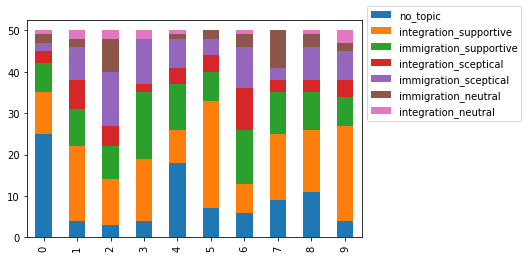

In [ ]:
## plot metrics over iterations
metrics_dic_lst = []
n_sample = 0
for key_iter, value_metrics_dic in learner.metrics.items():
    metrics_dic_iter = {key: value_metrics_dic[key] for key in value_metrics_dic if key not in ["eval_label_gold_raw", "eval_label_predicted_raw"]}
    metrics_dic_iter = {"iter_samp_total": n_sample, **metrics_dic_iter}
    metrics_dic_lst.append(metrics_dic_iter)
    n_sample += N_SAMPLE_AL

df_metrics = pd.DataFrame(metrics_dic_lst)
#df_metrics.plot(x="iter", subplots=[("iter", "eval_f1_macro"), ("iter", "eval_f1_micro"), ("iter", "eval_accuracy_balanced")])

df_metrics.plot(x="iter_samp_total", y="eval_f1_macro", grid=True)
df_metrics.plot(x="iter_samp_total", y="eval_f1_micro", grid=True)
#df_metrics.plot(x="iter_samp_total", y="eval_accuracy_balanced")



In [ ]:
## plot label distribution over iterations

df_label_dist = pd.DataFrame(sample_label_distribution)

df_label_dist.plot(kind="bar", stacked=True, legend=True).legend(loc='center left', bbox_to_anchor=(1.0, 0.8))

# final label distribution in training data
print(df_corpus_train.label_text.value_counts())

## test other query strategies

In [ ]:
"""### breaking ties balanced
n_sample_al = N_SAMPLE_AL

#def sample_breaking_ties_balanced(self, n_sample_al=5):  # results_corpus=None, df_corpus=None, label_text_alphabetical=None,

hypo_prob_entail = learner.results_corpus["eval_hypo_probabilities_entail"]
# mapping entail probabilities to labels
hypo_prob_entail = [{label_text: round(entail_score, 4) for entail_score, label_text in zip(prob_entail, learner.label_text_alphabetical)} for prob_entail in hypo_prob_entail]

### splitting the data to introduce some balance
### Options:
## 1: ties per class: take K=N/n_label most unsure texts where class c is part of the tie. repeat for each class. must sum to N
## 2: ties + certainty per class: take 2/n most unsure texts overall + 2/n_label/n most sure texts for each class. must sum to N
# could lead to issues with severe minority classes when high-certainty examples are exhausted
# but can be good to see high certainty examples to as expert
## 3. ! could also later trie uncertainty splits by other meta-data rather than classes

## ties per class
df_label_balance = pd.DataFrame(hypo_prob_entail)
# add columns with entailment difference of highest probability tie and with the two labels of the tie
df_label_balance["tie_difference"] = df_label_balance.apply(lambda row: row.nlargest(n=2).diff().dropna().values[0], axis=1)
df_label_balance["tie_labels_text"] = df_label_balance.apply(lambda row: "++".join(row.nlargest(n=2).index.tolist()), axis=1)

test = {}
for label in label_text_alphabetical:
    df_tie_label = df_label_balance[df_label_balance["tie_labels_text"].str.contains(label)]
    print("Number of ties with the label: ", label, len(df_tie_label))
    test.update({label: df_tie_label})


# inefficient
entail_distance = [{"entail_distance": pd.Series(prob_entail.values()).nlargest(n=2).max() - pd.Series(prob_entail.values()).nlargest(n=2).min(), "labels_in_tie": pd.Series(prob_entail.keys())[pd.Series(prob_entail.values()).nlargest(n=2).index.tolist()].tolist()} for prob_entail in hypo_prob_entail]


# select N hardest ties for active learning
entail_distance_min = pd.Series(entail_distance).nsmallest(n=n_sample_al)

# model prediction
entail_max = [max(prob_entail, key=prob_entail.get) for prob_entail in hypo_prob_entail]

# write to clean df
df_corpus_ties = learner.df_corpus_original_update.copy(deep=True)
df_corpus_ties["probs_entail"] = hypo_prob_entail
df_corpus_ties["label_text_pred"] = entail_max

#df_corpus_ties_sample = df_corpus_ties[df_corpus_ties.index.isin(entail_distance_min.index)]
df_corpus_ties_sample = df_corpus_ties.iloc[entail_distance_min.index]
# shuffle for random training sequence instead of ordered by difficulty/ties/uncertainty
df_corpus_ties_sample = df_corpus_ties_sample.sample(frac=1, random_state=learner.seed)

# scale probabilities to sum to 1 to enable argilla to ingest it
df_corpus_ties_sample["probs_entail_scaled"] = [dict(zip(list(probs_entail_dic.keys()), np.array(list(probs_entail_dic.values())) / np.array(list(probs_entail_dic.values())).sum())) for probs_entail_dic in df_corpus_ties_sample.probs_entail]

index_al_sample = df_corpus_ties_sample.index.tolist()

df_corpus_ties_sample

#learner.index_al_sample = index_al_sample
#learner.df_corpus_al_sample = df_corpus_ties_sample"""